In [3]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.utils import np_utils
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout, Activation
from tensorflow.keras.models import Sequential
import math
from tensorflow.keras.models import load_model

from music21 import converter, instrument, note, chord, stream, key
import glob
import music21

from keras.utils import np_utils
import os

FONTSIZE=24
plt.rcParams['figure.figsize']=(15,8)
plt.rcParams['font.size']=FONTSIZE

# Load in Generator

In [3]:
model=load_model('./results_fifths/ConvGan_fifths_Gstrides_12_2_Dstrides_12_2_G_epoch_150.h5')

# Produce Images

In [4]:
def generate_latent_space(n_samples,latent_dim):
    
    xinput=np.random.randn(n_samples*latent_dim)
    xinput=xinput.reshape((n_samples,latent_dim))
    
    return xinput

In [5]:
xinput=generate_latent_space(1,latent_dim=100)
x_fake=model.predict(xinput)
print(x_fake.shape)

(1, 96, 96, 4)


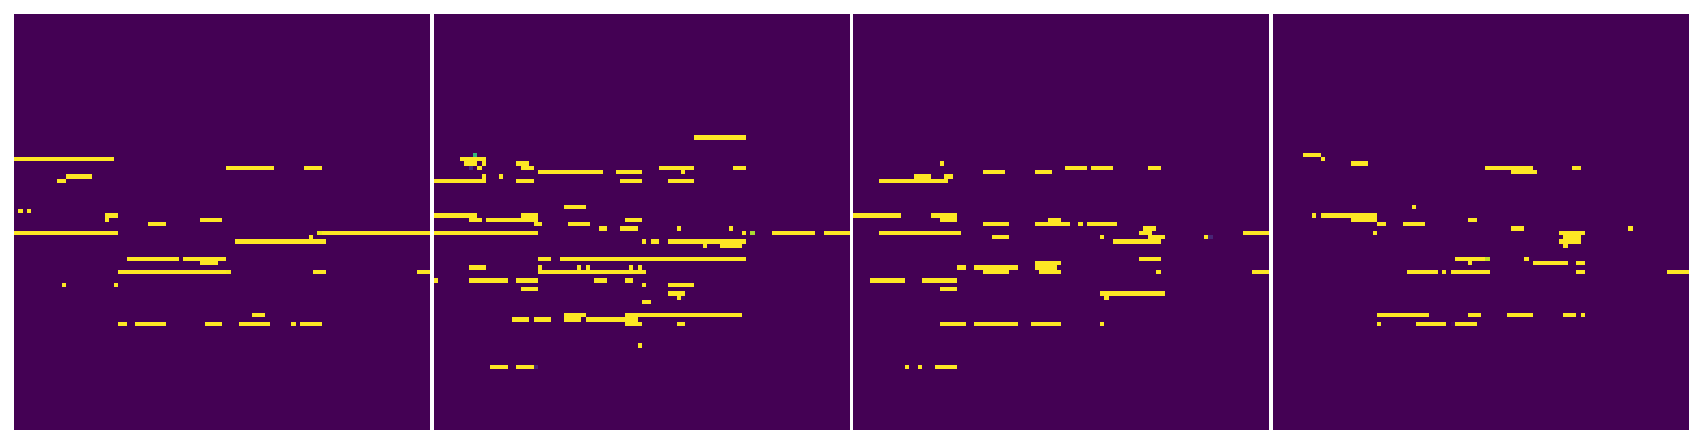

In [11]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake[0, :, :, i])
plt.subplots_adjust(wspace=0.01,hspace=0.01)

(-0.5, 383.5, 95.5, -0.5)

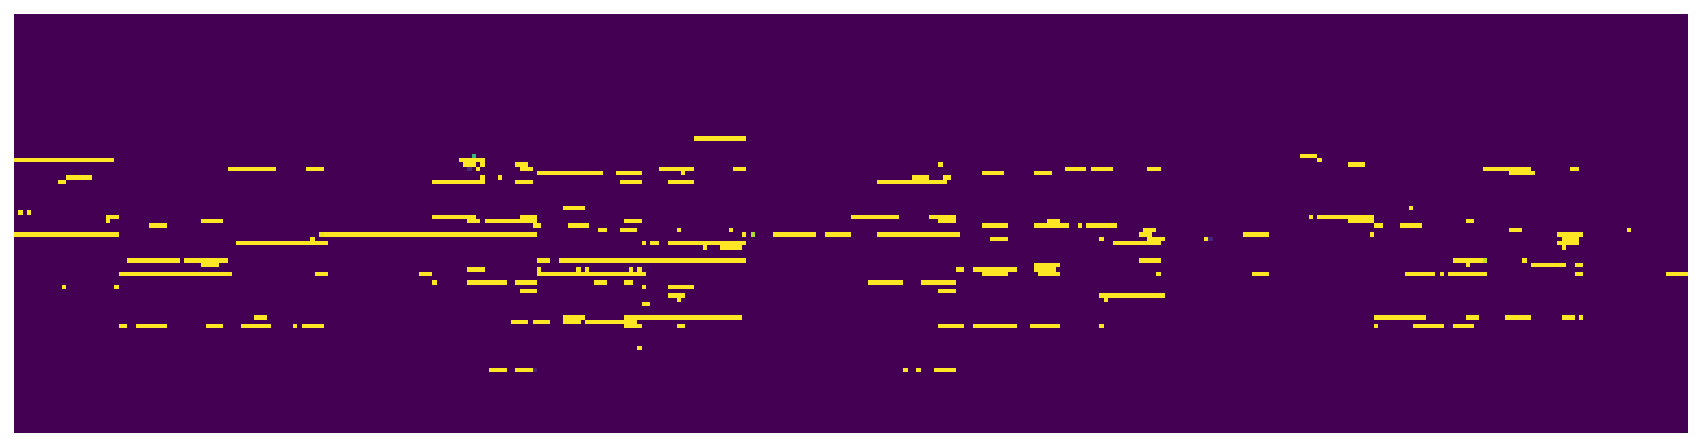

In [25]:
image=np.zeros((96,96*4))
image[:,:96]=x_fake[0,:,:,0]
image[:,96:96*2]=x_fake[0,:,:,1]
image[:,96*2:96*3]=x_fake[0,:,:,2]
image[:,96*3:]=x_fake[0,:,:,3]

plt.imshow(image)
plt.axis('off')

In [57]:
print(x_fake[0,:,10,0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Convert Images to MIDIs

In [5]:
# make a dictionary that maps ints to notes

#this will have key=integer value=pitch

#I'm dropping our lowest octave down to 0 and moving up 8 so our images can be squares

pitch_dict_fifths={}

min_octave=0
num_octaves=8

notes=['A','E','B','F#','C#','G#','D#','A#','F','C','G','D']
num_notes=len(notes)

count=-1
for i in range(num_octaves):
    for j in range(num_notes):
        count+=1
        octave=min_octave+i
        note_tmp=notes[j]
        pitch=str(note_tmp)+str(octave)
        
        pitch_dict_fifths[int(count)]=pitch
        
num_pitches=count+1
print(num_pitches)

96


In [5]:
print(pitch_dict_fifths[54])

D#4


In [6]:
def convert_to_midi(x_fake, filename, pitch_dict,confidence=0.8,size=96,num_channels=4,pixel_length=float(1/12) ):
    '''
    x_fake - generator produced image. shape=(1,size,size,num_channels)
    confidence - value pixel must have to be considered a note
    size - image size
    num_channels - number of image channels
    pixel_length - conversion from pixels to offsets 1 column=pixel_length offsets
    '''
    
    #convert image with channels to one continuous image
    image=np.zeros((size,size*num_channels))
    for i in range(num_channels):
        image[:,size*i:size*(i+1)]=x_fake[0,:,:,i]
    
    #collect offsets, pitches and durations
    
    offsets=[]
    pitches=[]
    durations=[]
    for row in range(image.shape[0]):
        
        note_previous=False #this will help us fill durations, does the previous column in this row contain a note?
        
        for column in range(image.shape[1]):
            
            offset=pixel_length*column
            pitch=pitch_dict[row]
            
            if image[row,column]>=confidence:
                #we have a note at this pixel
                
                if note_previous:
                    # the current pixel is a continuation of a previous note
                    durations[-1]+=pixel_length
                    
                elif not note_previous:
                    # the current pixel is the start of a new note
                    offsets.append(offset)
                    pitches.append(pitch)
                    durations.append(pixel_length) 
                
                note_previous=True
            else:
                note_previous=False
    
                
    #convert offsets, pitches, and durations to MIDI file
    output_notes=[]
    for i in range(len(pitches)):
        
        pitch=pitches[i]
        offset=offsets[i]
        duration=durations[i]
        
        new_note = note.Note(pitch,ql=duration)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
        
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=filename)
    
    
    

In [70]:
midi_file=convert_to_midi(x_fake,filename='test_output.mid',pitch_dict=pitch_dict_fifths)

In [73]:
xinput=generate_latent_space(1,latent_dim=100)
x_fake=model.predict(xinput)
print(x_fake.shape)

(1, 96, 96, 4)


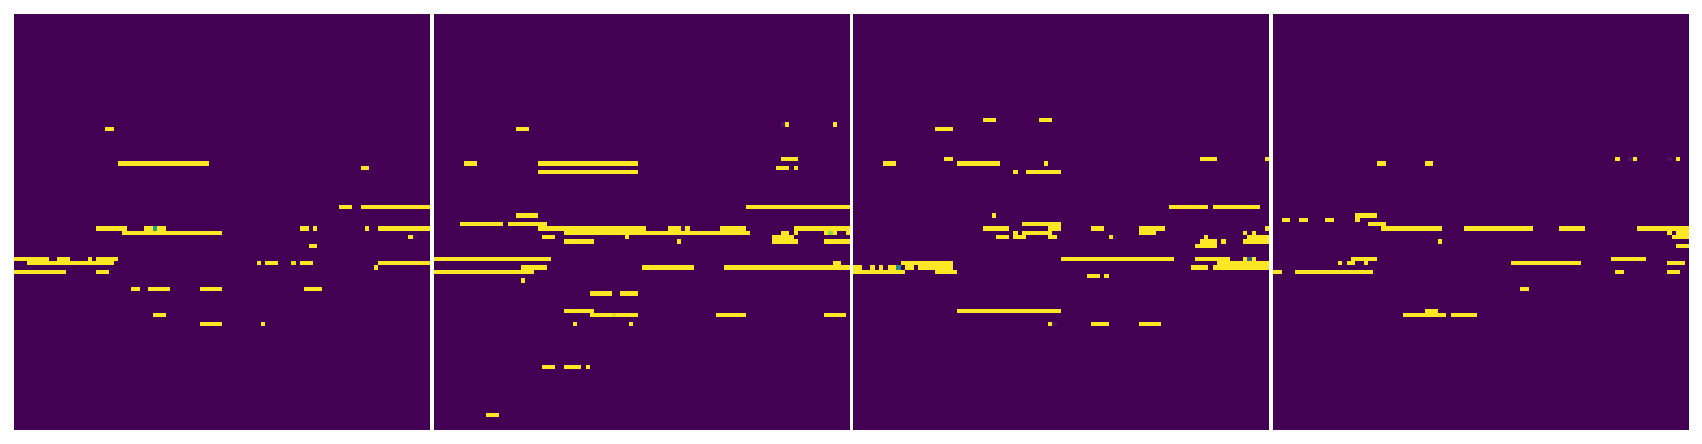

In [74]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake[0, :, :, i])
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [75]:
midi_file=convert_to_midi(x_fake,filename='test_output2.mid',pitch_dict=pitch_dict_fifths)

In [76]:
xinput=generate_latent_space(1,latent_dim=100)
x_fake=model.predict(xinput)
print(x_fake.shape)

(1, 96, 96, 4)


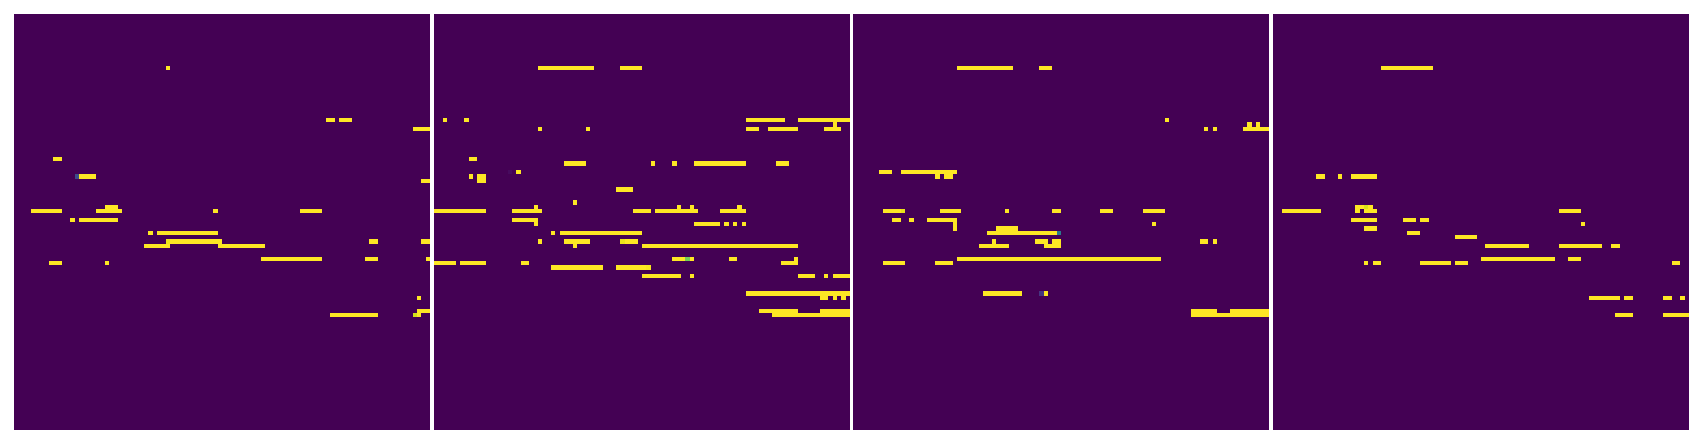

In [77]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake[0, :, :, i])
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [78]:
midi_file=convert_to_midi(x_fake,filename='test_output3.mid',pitch_dict=pitch_dict_fifths)

# Further training of the fifths model (the generator has become much more successful than the discriminator)

In [28]:
model=load_model('./results_fifths2/ConvGan_fifths_Gstrides_12_2_Dstrides_12_2_G_epoch_100.h5')

In [45]:
xinput=generate_latent_space(1,latent_dim=100)
x_fake=model.predict(xinput)
print(x_fake.shape)

(1, 96, 96, 4)


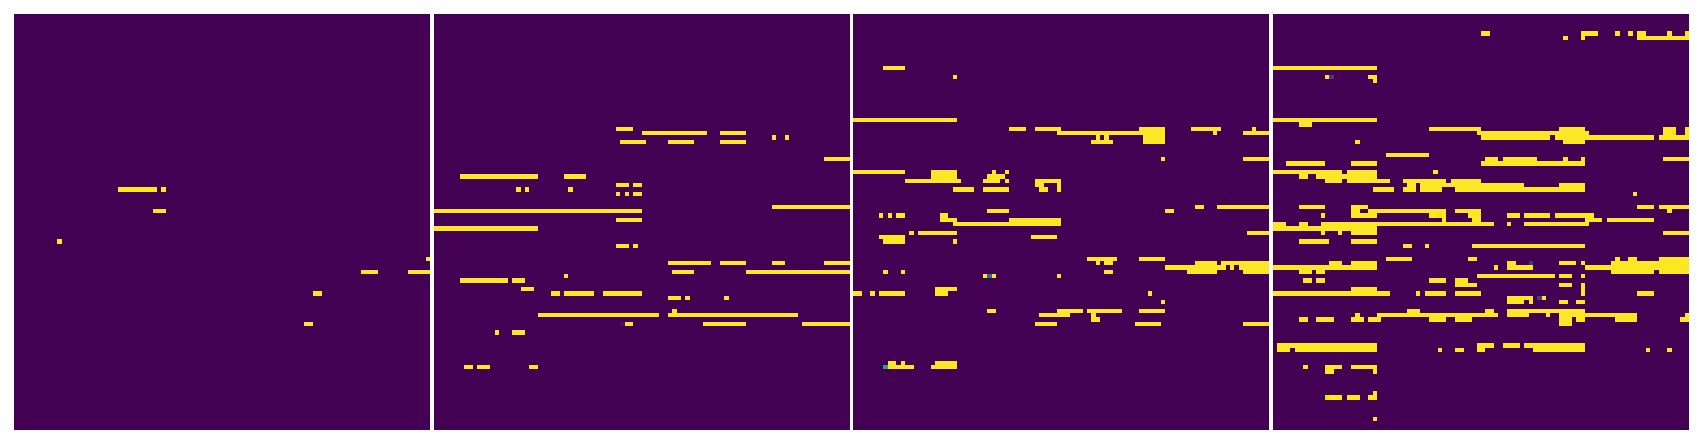

In [46]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake[0, :, :, i])
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [47]:
midi_file=convert_to_midi(x_fake,filename='fifths2_1.mid',pitch_dict=pitch_dict_fifths)

# Let's try our linear images

In [82]:


pitch_dict_linear={}

min_octave=0
num_octaves=8

notes=['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
num_notes=len(notes)

count=-1
for i in range(num_octaves):
    for j in range(num_notes):
        count+=1
        octave=min_octave+i
        note_tmp=notes[j]
        pitch=str(note_tmp)+str(octave)
        
        pitch_dict_linear[int(count)]=pitch
        
num_pitches=count+1
print(num_pitches)

96


In [84]:
model=load_model('./results_linear/ConvGan_linear_Gstrides_12_2_Dstrides_12_2_epoch_150.h5')

In [85]:
xinput=generate_latent_space(1,latent_dim=100)
x_fake=model.predict(xinput)
print(x_fake.shape)

(1, 96, 96, 4)


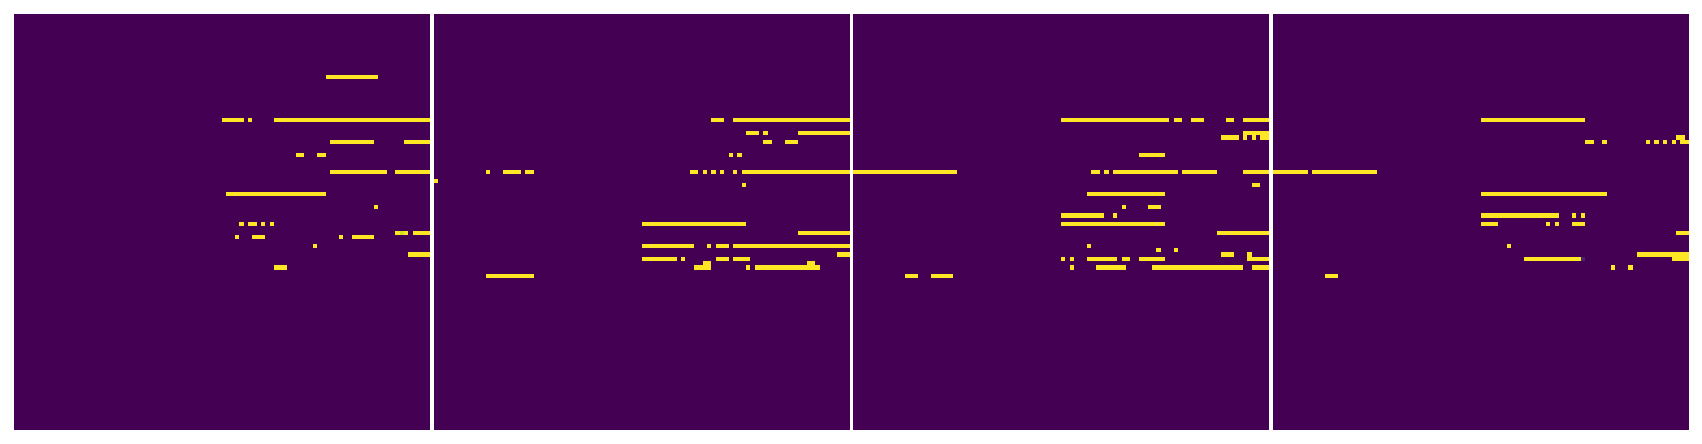

In [86]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake[0, :, :, i])
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [87]:
midi_file=convert_to_midi(x_fake,filename='test_output_linear.mid',pitch_dict=pitch_dict_linear)

In [90]:
xinput=generate_latent_space(1,latent_dim=100)
x_fake=model.predict(xinput)
print(x_fake.shape)

(1, 96, 96, 4)


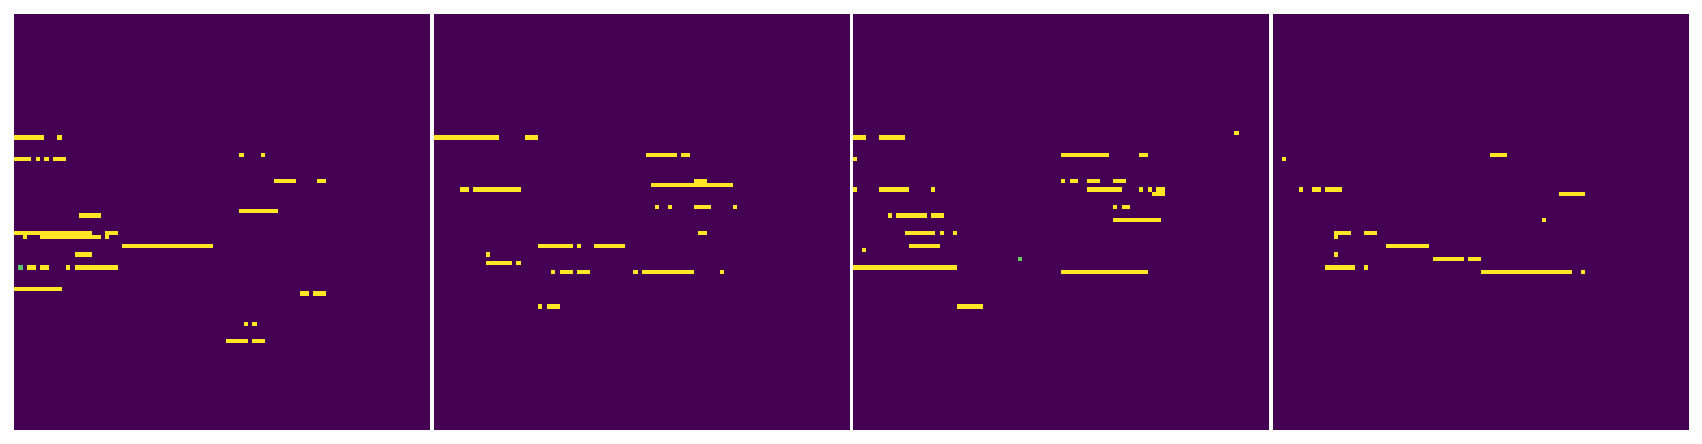

In [91]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake[0, :, :, i])
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [92]:
midi_file=convert_to_midi(x_fake,filename='test_output_linear2.mid',pitch_dict=pitch_dict_linear)

# This is our fifths model with disc filters 32 32 and generator latent space 32

In [9]:
model=load_model('./results_fifths_smaller/ConvGan_fifths_gen_feature_32_disc_filters_32_32_Gstrides_12_2_Dstrides_12_2_G_epoch_250.h5')

In [10]:
xinput=generate_latent_space(1,latent_dim=100)
x_fake=model.predict(xinput)
print(x_fake.shape)

(1, 96, 96, 4)


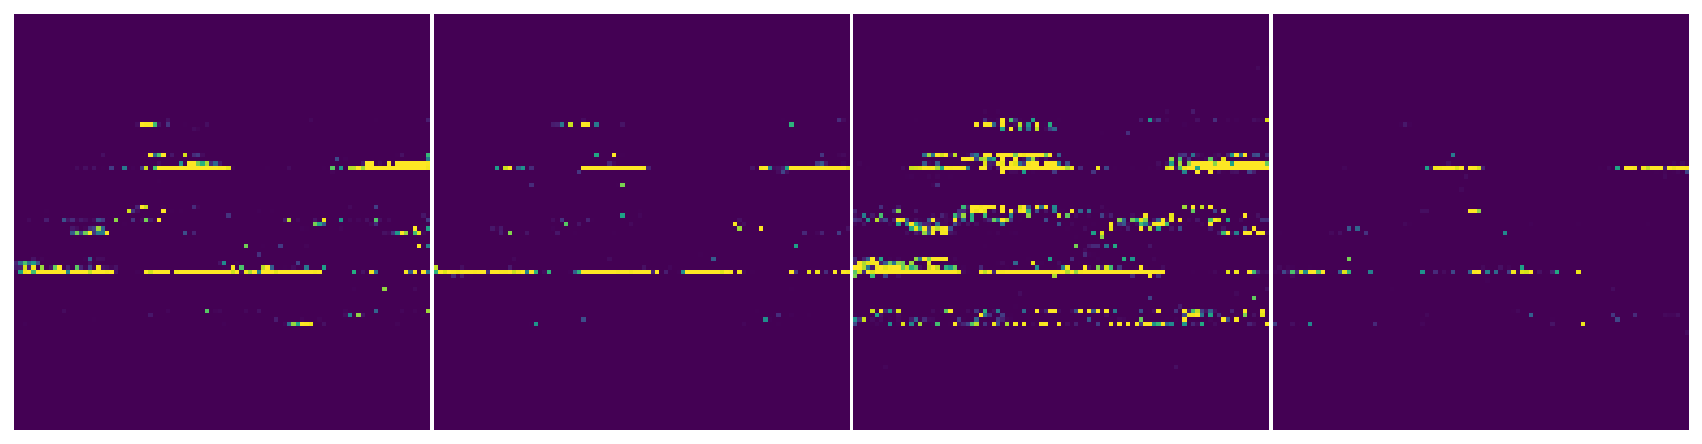

In [11]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake[0, :, :, i])
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [12]:
midi_file=convert_to_midi(x_fake,filename='fifths_filters_32_32_gen_feature_32_1.mid',pitch_dict=pitch_dict_fifths)

In [19]:
xinput=generate_latent_space(1,latent_dim=100)
x_fake=model.predict(xinput)
print(x_fake.shape)

(1, 96, 96, 4)


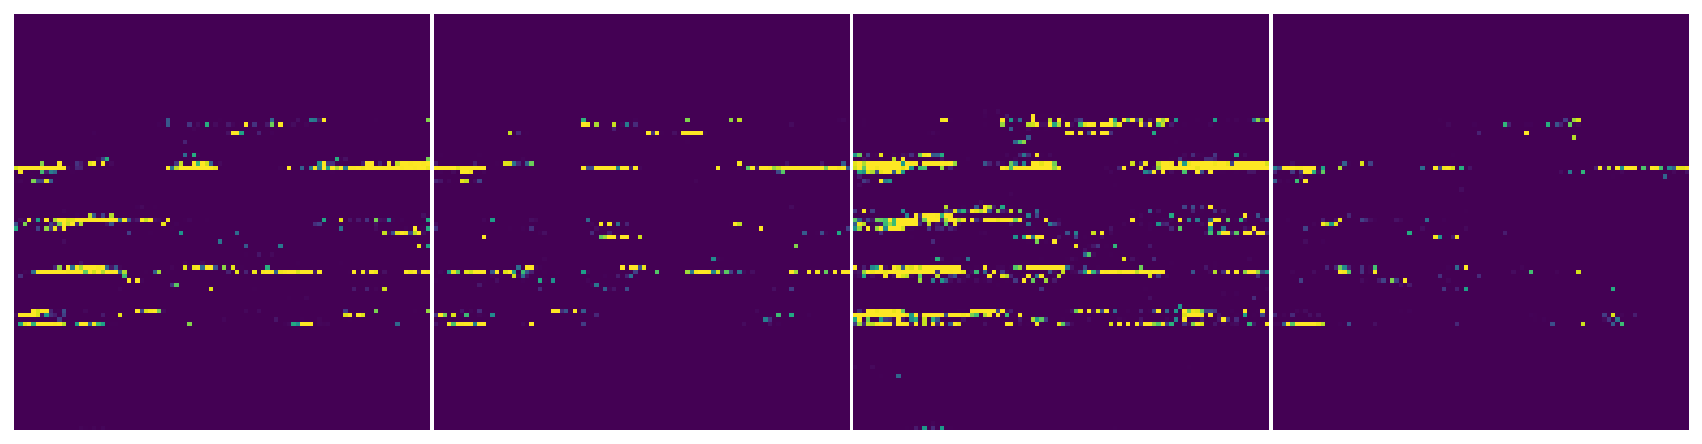

In [20]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake[0, :, :, i])
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [21]:
midi_file=convert_to_midi(x_fake,filename='fifths_filters_32_32_gen_feature_32_2.mid',pitch_dict=pitch_dict_fifths,confidence=0.95)

In [26]:
xinput=generate_latent_space(1,latent_dim=100)
x_fake=model.predict(xinput)
print(x_fake.shape)

(1, 96, 96, 4)


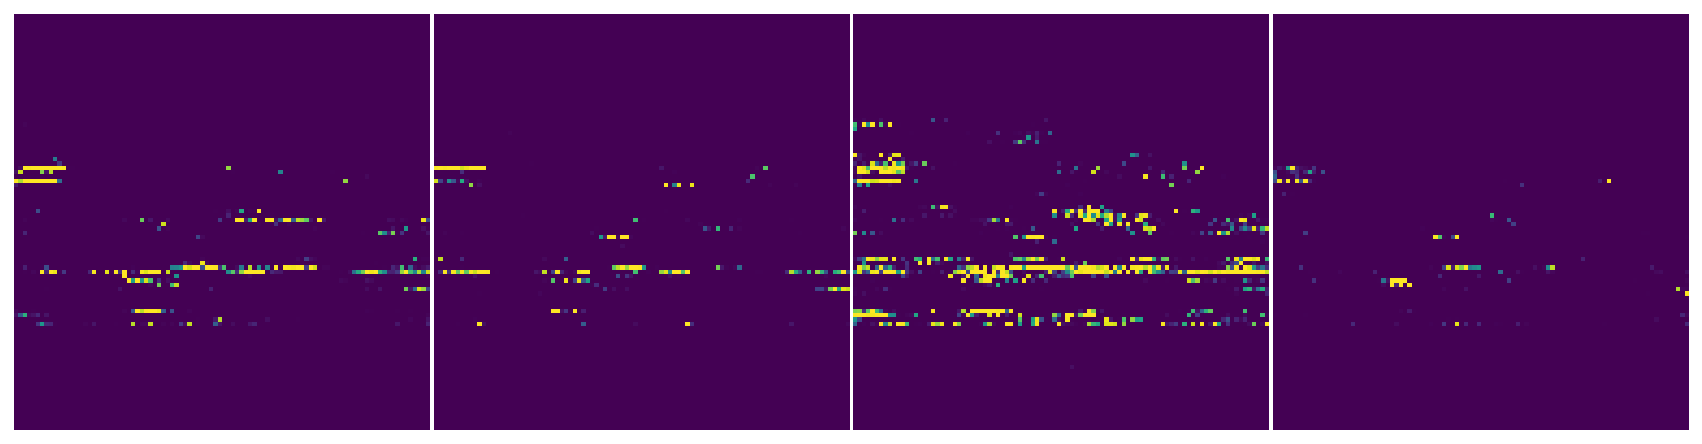

In [27]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake[0, :, :, i])
plt.subplots_adjust(wspace=0.01,hspace=0.01)

# Here's the model where I attempted to use updating boosts but a bug kept it at boost=1 for both

In [11]:
model=load_model('./results_fifths_smaller_bug/ConvGan_fifths_gen_feature_32_disc_filters_32_32_Gstrides_12_2_Dstrides_12_2_G_epoch_750.h5')

In [20]:
xinput=generate_latent_space(1,latent_dim=100)
x_fake=model.predict(xinput)
print(x_fake.shape)

(1, 96, 96, 4)


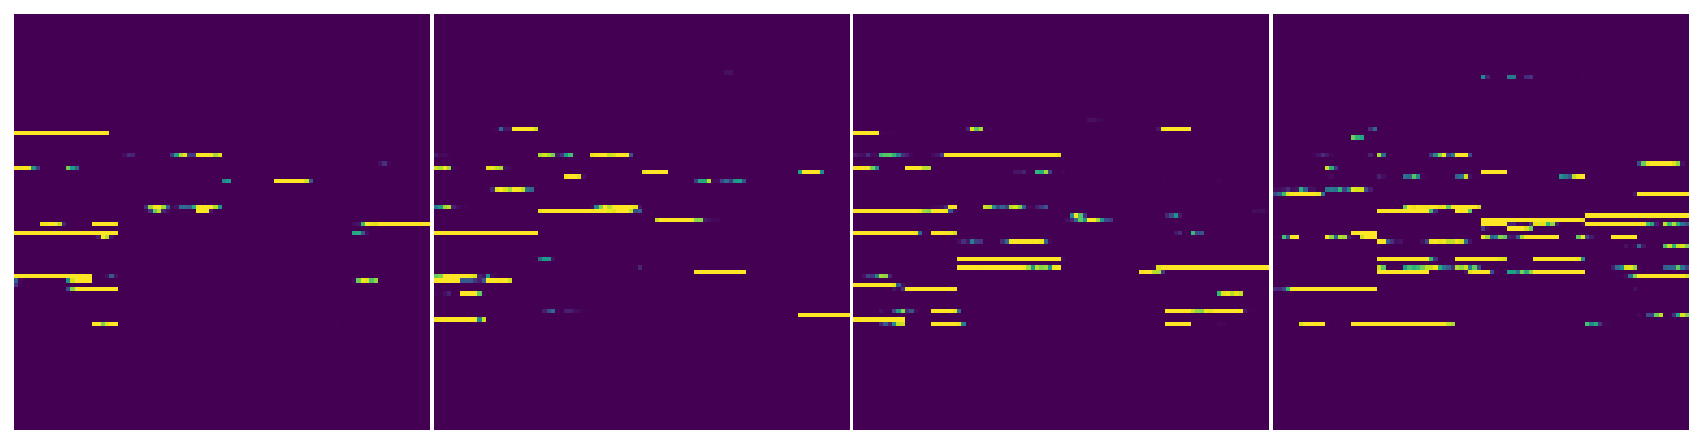

In [21]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake[0, :, :, i])
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [22]:
midi_file=convert_to_midi(x_fake,filename='fifths_smaller_bug1.mid',pitch_dict=pitch_dict_fifths)

# Here's where the boost actually worked, first 750 epochs

In [7]:
model=load_model('./results_fifths_smaller_boost/ConvGan_fifths_gen_feature_32_disc_filters_32_32_Gstrides_12_2_Dstrides_12_2_G_epoch_750.h5')

In [10]:
xinput=generate_latent_space(1,latent_dim=100)
x_fake=model.predict(xinput)
print(x_fake.shape)

(1, 96, 96, 4)


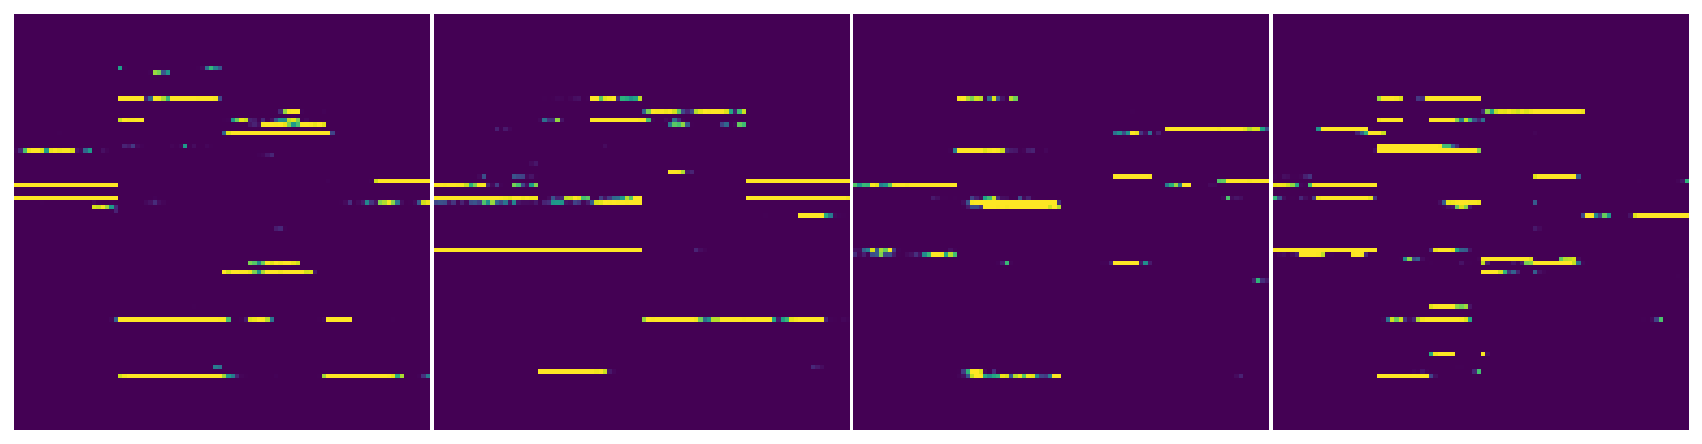

In [15]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake[0, :, :, i],origin='lower')
plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.savefig('./presentation/song.png',bbox_inches='tight')

In [16]:
midi_file=convert_to_midi(x_fake,filename='./presentation/fifths_smaller_boost_present.mid',pitch_dict=pitch_dict_fifths)